<a href="https://colab.research.google.com/github/yusufmkh/recommender-model/blob/main/Honours_CS_Project_Recommender_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

The proposed recommender model helps hospitality employers find the right staff faster by matching candidate to their jobs based on the skills, candidate and work preferences, and past work experience which the model also uses to match candidates to jobs.

An example of matching a new job to existing candidate profiles is also implemented in the end.

# Model intuition

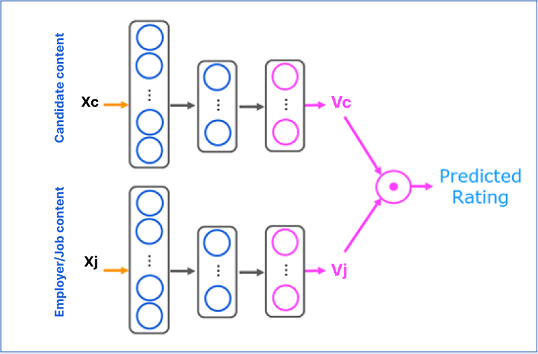

The **content-based filtering with neural networks** was chosen for modelling. The overall structure is depited where the constructed candidate and job datasets are fed into corresponding neural networks both outputting the same number of values. To make a prediction, the dot product of the output values are taken which then gives the percentage of matches between the candidate and job inputs.

This approach was originally proposed in the Machine Learning Specialization on Coursera by Andrew Ng (2024) for recommending movies to users based on the movie genres. The proposed recommender model is inspired by Andrew Ng's movie recommendation model, so it uses the overall model architechture and most of the techniques from the movie model but also adds significant changes to make it work for the candidate recommender system.

# Importing libraries

In [1]:
# Install specific TensorFlow and Keras versions before importing
!pip install tf-keras==2.15 --quiet
!pip install tensorflow==2.15 --quiet
!pip install keras==2.15 --quiet

In [2]:
# Data analysis
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Pre-processing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# Modeling
import tensorflow as tf
from tensorflow import keras

# Evaluation and model selection
from sklearn.model_selection import cross_val_score, cross_validate

# Metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, roc_auc_score, make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Datasets

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
candidate_samples = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/candidate_samples.xlsx')
job_samples = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/job_samples.xlsx')
targets = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/TargetFeature.xlsx')

# Data understanding

The datasets used for modelling are candidates and jobs as the training, and the targets. They are constructed manually since the platform has not gathered enough data yet. Various tools have been explored to generate synthetic data from a real dataset and two python packages were considered: The Synthetic Data Vault (specifically its GaussianCopulaSynthesizer) and DataSynthesizer, but no synthetic data was generated because of synthetic nature which may not present the samples in the real dataset. The model will be training periodically as the platform gains more users and job postings which will ensure the accuracy of predictions. This model will serve as the proof of concept in the beginning.

In [5]:
candidate_samples

,user_id,skill_1,skill_2,skill_3,company_type,company_size,job_type,pay_range
0,2,communication,waiting,runner,restaurant,small,full-time,pay30_35
1,3,runner,leadership,waiting,restaurant,medium,part-time,pay20_30
2,4,leadership,communication,barista,restaurant,small,full-time,pay35_40
3,5,waiting,runner,drinks,restaurant,large,part-time,pay20_30
4,6,communication,barista,waiting,restaurant,small,contract,pay20_30
5,7,leadership,communication,dring,restaurant,small,full-time,pay35_40
6,8,waiting,runner,brista,restaurant,large,part-time,pay20_30
7,9,communication,barista,waiting,restaurant,small,contract,pay30_35
8,10,leadership,communication,barista,restaurant,medium,part-time,pay35_40
9,11,waiting,runner,barista,restaurant,large,full-time,pay40_45


In [6]:
job_samples

,job_id,skill_1,skill_2,skill_3,company_type,company_size,job_type,pay_range
0,1,barista,waiting,runner,restaurant,small,full-time,pay30_35
1,2,runner,leadership,waiting,restaurant,medium,part-time,pay20_30
2,3,leadership,communication,barista,restaurant,small,full-time,pay35_40
3,4,waiting,runner,barista,restaurant,large,part-time,pay20_30
4,5,communication,barista,waiting,restaurant,small,contract,pay20_30
5,6,barista,waiting,runner,restaurant,medium,full-time,pay30_35
6,7,runner,leadership,waiting,restaurant,medium,contract,pay20_30
7,8,leadership,communication,barista,restaurant,small,full-time,pay45_50
8,9,waiting,runner,barista,restaurant,large,part-time,pay20_30
9,10,communication,barista,waiting,restaurant,small,part-time,pay40_45


Candidates and jobs datasets have identical attributes since the skills, company type, company size, job type, and pay range are the main factors the model uses to determine if a candidate is a match for a specific job. The ID columns from both datasets will be removed in the preprocessing because they do not measure or represent any meaningful preference, but they will be added back later when the candidate predictions from the model are mapped to a job.

In [7]:
targets.T

,0,1,2,3,4,5,6,7,8,9
is_match,1,0,1,1,0,1,1,0,1,0


The target dataset will be used the truth during the model training and has only one column which holds either 1 or 0 meaning a match or not a match respectively.

In [8]:
candidate_samples.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       10 non-null     int64 
 1   skill_1       10 non-null     object
 2   skill_2       10 non-null     object
 3   skill_3       10 non-null     object
 4   company_type  10 non-null     object
 5   company_size  10 non-null     object
 6   job_type      10 non-null     object
 7   pay_range     10 non-null     object
dtypes: int64(1), object(7)
memory usage: 768.0+ bytes


In [9]:
job_samples.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   job_id        10 non-null     int64 
 1   skill_1       10 non-null     object
 2   skill_2       10 non-null     object
 3   skill_3       10 non-null     object
 4   company_type  10 non-null     object
 5   company_size  10 non-null     object
 6   job_type      10 non-null     object
 7   pay_range     10 non-null     object
dtypes: int64(1), object(7)
memory usage: 768.0+ bytes


In [10]:
targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   is_match  10 non-null     int64
dtypes: int64(1)
memory usage: 208.0 bytes


# Preprocessing

In [11]:
# Removing ID columns from both datasets
candidate_ids = candidate_samples.pop('user_id')
job_ids = job_samples.pop('job_id')

In [12]:
candidate_samples

,skill_1,skill_2,skill_3,company_type,company_size,job_type,pay_range
0,communication,waiting,runner,restaurant,small,full-time,pay30_35
1,runner,leadership,waiting,restaurant,medium,part-time,pay20_30
2,leadership,communication,barista,restaurant,small,full-time,pay35_40
3,waiting,runner,drinks,restaurant,large,part-time,pay20_30
4,communication,barista,waiting,restaurant,small,contract,pay20_30
5,leadership,communication,dring,restaurant,small,full-time,pay35_40
6,waiting,runner,brista,restaurant,large,part-time,pay20_30
7,communication,barista,waiting,restaurant,small,contract,pay30_35
8,leadership,communication,barista,restaurant,medium,part-time,pay35_40
9,waiting,runner,barista,restaurant,large,full-time,pay40_45


## Encoding

The one-hot encoding was chosen because it splits columns by the class labels and generates a binary value for each column that can be easier to compute in the neural network and it is more convenient to implement than the label encoding which is performed on a single vector rather than a matrix. The custom “one_hot_encoder()” function for the encoding was also constructed to not repeat the encoder code on the datasets.

In [13]:
ohe = OneHotEncoder(handle_unknown='ignore')

In [14]:
def one_hot_encoder(df):
  df_enc = ohe.fit_transform(df).toarray()
  df_enc_features = ohe.get_feature_names_out(df.columns)
  df_enc_data = pd.DataFrame(df_enc, columns=df_enc_features)

  return df_enc_data

In [15]:
candidate_samples_enc = one_hot_encoder(candidate_samples)
candidate_samples_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   skill_1_communication    10 non-null     float64
 1   skill_1_leadership       10 non-null     float64
 2   skill_1_runner           10 non-null     float64
 3   skill_1_waiting          10 non-null     float64
 4   skill_2_barista          10 non-null     float64
 5   skill_2_communication    10 non-null     float64
 6   skill_2_leadership       10 non-null     float64
 7   skill_2_runner           10 non-null     float64
 8   skill_2_waiting          10 non-null     float64
 9   skill_3_barista          10 non-null     float64
 10  skill_3_brista           10 non-null     float64
 11  skill_3_dring            10 non-null     float64
 12  skill_3_drinks           10 non-null     float64
 13  skill_3_runner           10 non-null     float64
 14  skill_3_waiting          10 n

In [16]:
job_samples_enc = one_hot_encoder(job_samples)
job_samples_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   skill_1_barista          10 non-null     float64
 1   skill_1_communication    10 non-null     float64
 2   skill_1_leadership       10 non-null     float64
 3   skill_1_runner           10 non-null     float64
 4   skill_1_waiting          10 non-null     float64
 5   skill_2_barista          10 non-null     float64
 6   skill_2_communication    10 non-null     float64
 7   skill_2_leadership       10 non-null     float64
 8   skill_2_runner           10 non-null     float64
 9   skill_2_waiting          10 non-null     float64
 10  skill_3_barista          10 non-null     float64
 11  skill_3_runner           10 non-null     float64
 12  skill_3_waiting          10 non-null     float64
 13  company_type_restaurant  10 non-null     float64
 14  company_size_large       10 n

In [17]:
candidate_samples_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   skill_1_communication    10 non-null     float64
 1   skill_1_leadership       10 non-null     float64
 2   skill_1_runner           10 non-null     float64
 3   skill_1_waiting          10 non-null     float64
 4   skill_2_barista          10 non-null     float64
 5   skill_2_communication    10 non-null     float64
 6   skill_2_leadership       10 non-null     float64
 7   skill_2_runner           10 non-null     float64
 8   skill_2_waiting          10 non-null     float64
 9   skill_3_barista          10 non-null     float64
 10  skill_3_brista           10 non-null     float64
 11  skill_3_dring            10 non-null     float64
 12  skill_3_drinks           10 non-null     float64
 13  skill_3_runner           10 non-null     float64
 14  skill_3_waiting          10 n

In [18]:
job_samples_enc

,skill_1_barista,skill_1_communication,skill_1_leadership,skill_1_runner,skill_1_waiting,skill_2_barista,skill_2_communication,skill_2_leadership,skill_2_runner,skill_2_waiting,...,company_size_medium,company_size_small,job_type_contract,job_type_full-time,job_type_part-time,pay_range_pay20_30,pay_range_pay30_35,pay_range_pay35_40,pay_range_pay40_45,pay_range_pay45_50
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
9,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


## Splitting

Usually It is important to split the dataset into train and test before any scaling, normalisation, or modelling because it may cause data leakage otherwise which happens when training data contains some information about the test data, more specifically, when the data is normalised before the split, it calculates the value ranges from the whole dataset thus revealing some value ranges later in the test data and this unreasonably improves the accuracy of models. It is always recommended to do scaling, normalization, encoding, and modelling only on the training data after the split (Brownlee, 2020) but in this case, the datasets are split after encoding because of the modelling requirements since the input dataset shapes are passed to the model configuration and if one-hot encoding, which is the encoding choice for the datasets, is performed after the split and train shape is passed to the model configuration, either train or test dataset will have a bigger or smaller shape thus not fitting to the modelling requirement. Since the normalization is not happening in the datasets, it can be safe to say that splitting after encoding does not change the nature of the datasets in this project.

In [19]:
# Splitting the training and target datasets
job_train, job_test = train_test_split(job_samples_enc, train_size=0.70, shuffle=True, random_state=1)
candidate_train, candidate_test = train_test_split(candidate_samples_enc, train_size=0.70, shuffle=True, random_state=1)
y_train, y_test = train_test_split(targets,    train_size=0.70, shuffle=True, random_state=1)

The record shuffling applied in the splitting and to produce the same splitting results across datasets, the random_state parameter is set to 1 in all train_test_split() calls (scikit-learn developers, 2024).

# Modelling

In [20]:
num_outputs = 32
tf.random.set_seed(1)
candidate_NN = tf.keras.models.Sequential([
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_outputs, activation='linear')
])

job_NN = tf.keras.models.Sequential([
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_outputs, activation='linear')
])

# create the candidate input and point to the base network
input_candidate = tf.keras.layers.Input(shape=(candidate_samples_enc.shape[1],))
vc = candidate_NN(input_candidate)
vc = tf.linalg.l2_normalize(vc, axis=1)

# create the job input and point to the base network
input_job = tf.keras.layers.Input(shape=(job_samples_enc.shape[1],))
vj = job_NN(input_job)
vj = tf.linalg.l2_normalize(vj, axis=1)

# compute the dot product of the two vectors vc and vj
output = tf.keras.layers.Dot(axes=1)([vc, vj])

# specify the inputs and output of the model
model = tf.keras.Model([input_candidate, input_job], output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 26)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 25)]                 0         []                            
                                                                                                  
 sequential (Sequential)     (None, 32)                   43936     ['input_1[0][0]']             
                                                                                                  
 sequential_1 (Sequential)   (None, 32)                   43680     ['input_2[0][0]']             
                                                                                              

The Sequential model by keras was used to better organise layers in constructing each network although another option keras Functional API is more flexible and can handle models with non-linear topology and shared layers (fchollet, 2023) because the individual networks used are quite simple thus the Sequential but the second half of the model code uses the Functional API to create input nodes for the candidate and job networks and also adding a dot product layer and building the model with the inputs and output specifications. This format of the model construction allows for more flexibility in how the model components are interconnected considering benefits of both Sequential and Functional API approaches.

In [21]:
tf.random.set_seed(1)
cost_fn = tf.keras.losses.MeanSquaredError()
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss=cost_fn, metrics=['accuracy'])

Since the neural networks above uses linear activation functions, the Mean Squared Error, which is the average of the difference between the target and prediction, is chosen as the cost function. To get the optimal weights and biases in the backpropagation, the Adaptive Moment Estimation (Adam) optimizer is being used to get to the global minimum faster in gradient calculations at each iteration. The Adam optimizer is a better version of Stochastic Gradient Descent (SGD), which works by randomly selecting one data sample at each epoch for model parameters, because the Adam optimizer achieves an adaptive learning rate by incorporating both the first moment (mean) and second moment (uncentered variance) of the gradients unlike the SGD that maintains a single learning rate during training (Gupta, 2024).

The accuracy metric was chosen, since it is a straightforward metric, to evaluate model predictions in the later stages.

In [22]:
tf.random.set_seed(1)
model.fit([candidate_train, job_train], y_train, epochs=30)

Epoch 1/30
1/1 [==============================] - 4s 4s/step - loss: 0.5057 - accuracy: 0.4286
Epoch 2/30
1/1 [==============================] - 0s 51ms/step - loss: 0.1078 - accuracy: 1.0000
Epoch 3/30
1/1 [==============================] - 0s 34ms/step - loss: 0.0493 - accuracy: 1.0000
Epoch 4/30
1/1 [==============================] - 0s 23ms/step - loss: 0.0384 - accuracy: 1.0000
Epoch 5/30
1/1 [==============================] - 0s 51ms/step - loss: 0.0137 - accuracy: 1.0000
Epoch 6/30
1/1 [==============================] - 0s 47ms/step - loss: 0.0091 - accuracy: 1.0000
Epoch 7/30
1/1 [==============================] - 0s 18ms/step - loss: 0.0142 - accuracy: 1.0000
Epoch 8/30
1/1 [==============================] - 0s 15ms/step - loss: 0.0044 - accuracy: 1.0000
Epoch 9/30
1/1 [==============================] - 0s 53ms/step - loss: 0.0042 - accuracy: 1.0000
Epoch 10/30
1/1 [==============================] - 0s 25ms/step - loss: 0.0083 - accuracy: 1.0000
Epoch 11/30
1/1 [==============

# Testing and evaluation

The **Accuracy** is the chosen metric for the evaluation. At first, the loss reduction in the model training is depicted in accuracy and loss graph. Then, model testing is carried out with the test datasets for candidates, jobs, and target later illustrating the test predictions in the confusion matrix.

In [23]:
losses = pd.DataFrame(model.history.history)

<Axes: >

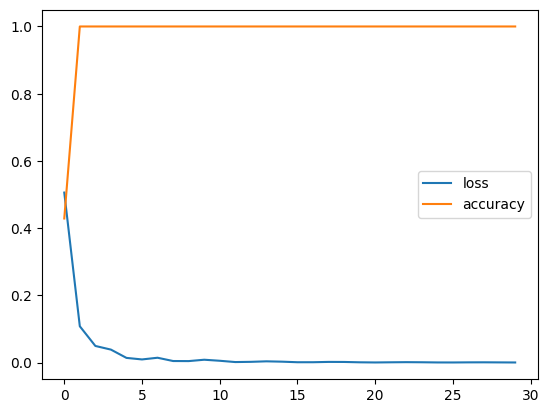

In [24]:
losses.plot()

In [25]:
y_pred = model.predict([candidate_test, job_test])
y_pred

1/1 [==============================] - 0s 441ms/step


array([[0.8316329 ],
       [0.8031466 ],
       [0.60606456]], dtype=float32)

In [26]:
y_pred = (y_pred > 0.5)
y_pred = y_pred.astype(int)
y_pred

array([[1],
       [1],
       [1]])

In [27]:
accuracy_score(y_test, y_pred)

0.6666666666666666

The test datasets were used to evaluate the prediction performance. Any prediction with over 50% probability is taken as truth and with that setting, the model has got 66% accuracy which is not bad, but the lack of appropriate data limited both training and testing which will be solved in the future model training and optimisations as more candidates register for the system and more jobs are posted.

<Axes: >

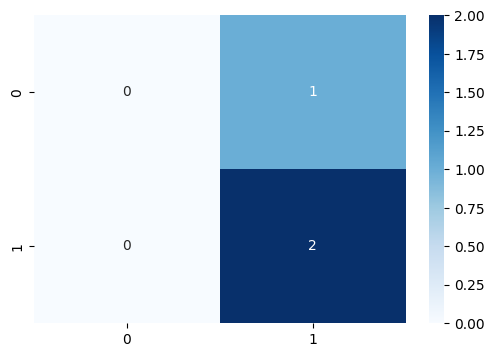

In [28]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g',
xticklabels=[0 , 1], yticklabels=[0, 1])

# Making predictions with new data

The fitted model can be used to predict candidate matches to jobs or vice versa. A demonstration of finding candidate matches to a new job is shown below. The same process can be used to predict job matches to a new candidate user as well.

## Predict (candidate matches) for a new job

In [29]:
job_id = 5
skill_1 = 'leadership'
skill_2 = 'communication'
skill_3 = 'runner'
company_type = 'restaurant'
company_size = 'medium'
job_type = 'full-time'
pay_range = 'pay30_35'

new_job = np.array([job_id, skill_1, skill_2, skill_3, company_type, company_size, job_type, pay_range])
new_job

array(['5', 'leadership', 'communication', 'runner', 'restaurant',
       'medium', 'full-time', 'pay30_35'], dtype='<U21')

The new prediction data structure resembles the sample datasets used for training and testing. For the prediction, a new data record needs to be multiplied by however many candidates there are in the system so the individual matches will be determined one-on-one basis.

In [30]:
job_vec = pd.DataFrame([new_job], columns=['job_id', 'skill_1', 'skill_2', 'skill_3', 'company_type', 'company_size', 'job_type', 'pay_range'])
job_vec

,job_id,skill_1,skill_2,skill_3,company_type,company_size,job_type,pay_range
0,5,leadership,communication,runner,restaurant,medium,full-time,pay30_35


In [31]:
job_vecs = pd.DataFrame(np.tile(job_vec, (len(candidate_samples_enc),1)), columns= job_vec.columns)
job_vecs

,job_id,skill_1,skill_2,skill_3,company_type,company_size,job_type,pay_range
0,5,leadership,communication,runner,restaurant,medium,full-time,pay30_35
1,5,leadership,communication,runner,restaurant,medium,full-time,pay30_35
2,5,leadership,communication,runner,restaurant,medium,full-time,pay30_35
3,5,leadership,communication,runner,restaurant,medium,full-time,pay30_35
4,5,leadership,communication,runner,restaurant,medium,full-time,pay30_35
5,5,leadership,communication,runner,restaurant,medium,full-time,pay30_35
6,5,leadership,communication,runner,restaurant,medium,full-time,pay30_35
7,5,leadership,communication,runner,restaurant,medium,full-time,pay30_35
8,5,leadership,communication,runner,restaurant,medium,full-time,pay30_35
9,5,leadership,communication,runner,restaurant,medium,full-time,pay30_35


In [32]:
job_vecs_ids = job_vecs.pop('job_id')

After getting enough records of the new job, the ID column will be extracted, and the same one-hot encoding is carried out on the dataset.

In [33]:
job_vecs_enc = ohe.transform(job_vecs).toarray()
job_vecs_enc_features = ohe.get_feature_names_out(job_vecs.columns)
job_vecs_enc_data = pd.DataFrame(job_vecs_enc, columns=job_vecs_enc_features)
job_vecs_enc_data

,skill_1_barista,skill_1_communication,skill_1_leadership,skill_1_runner,skill_1_waiting,skill_2_barista,skill_2_communication,skill_2_leadership,skill_2_runner,skill_2_waiting,...,company_size_medium,company_size_small,job_type_contract,job_type_full-time,job_type_part-time,pay_range_pay20_30,pay_range_pay30_35,pay_range_pay35_40,pay_range_pay40_45,pay_range_pay45_50
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
5,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
6,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
7,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
8,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
9,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [34]:
job_vecs_enc_data.shape

(10, 25)

In [35]:
candidate_samples_enc.shape

(10, 26)

In [36]:
job_pred = model.predict([candidate_samples_enc, job_vecs_enc_data])

1/1 [==============================] - 0s 48ms/step


In [37]:
job_pred

array([[0.93865484],
       [0.48305607],
       [0.97835   ],
       [0.92698145],
       [0.40443152],
       [0.97173387],
       [0.92771643],
       [0.45609927],
       [0.9527697 ],
       [0.9681093 ]], dtype=float32)

Using the candidate and prepared datasets, the model will make match predictions between the new job and all the existing candidate users and outputs the results as shown above.

In [38]:
job_pred = pd.DataFrame(job_pred)
job_pred.columns = ['match_percentage']

new_match_results = pd.concat([job_vecs_ids, candidate_ids, pd.DataFrame(job_pred)], axis=1)

In [39]:
new_match_results

,job_id,user_id,match_percentage
0,5,2,0.938655
1,5,3,0.483056
2,5,4,0.978350
3,5,5,0.926981
4,5,6,0.404432
5,5,7,0.971734
6,5,8,0.927716
7,5,9,0.456099
8,5,10,0.952770
9,5,11,0.968109


Once the predictions are made, they can be labelled as matches in percentage and mapped to the job and corresponding candidates with the Pandas’ concat() method. The new_match_results dataframe is the final candidate match results for the new job. This prediction process will be carried out every time when a new prediction either for a candidate or job is needed as a part of the program logic in the API backend.

# Saving the Recommender model as a file to use in the backend

In [40]:
# model.save('recommender_model.keras')

In order to use the trained model later in the backend or anywhere else, it needs to be saved and the model.save() method from keras will accomplishes the task by saving the entire model into a single file which include:

- Model’s architecture and configurations

- Learned weight values from training

- Model compilation information

- The optimizer and its state (this helps to restart the training later where it is left)

The saved model file will then be used elsewhere after loading it with the keras.models.load_model() method (Kovelamudi and Chollet, 2023) that will also be demonstrated in the “Integrating the recommender model” backend subsection.